# Setup

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from collections import defaultdict

In [2]:
CSV_DIR = 'clean'
def load_tables(csv_dir):
    tables = {}
    for path in glob.glob(csv_dir + '/*.csv'):
        fname = os.path.basename(path)
        name = fname.split('.')[0]
        tables[name] = pd.read_csv(path)
    add_indices(tables)
    return tables

def add_indices(tables):
  _table_names = ['actors', 'appearances', 'characters', 'episodes', 'hosts', 'impressions',
                 'seasons', 'sketches', 'titles', 'casts',
                ]
  table_to_index = dict(episodes='epid', impressions='impid', seasons='sid', titles='tid', actors='aid')
  for (tablename, idx_col) in table_to_index.items():
      tables[tablename].set_index(idx_col, drop=False, inplace=True)


tables = load_tables(CSV_DIR)

for name, table in tables.items():
    # I know, I know
    globals()[name] = table
# shortcut alias
apps = appearances
imps = impressions

# XXX: drop 43 for now, since I think we only have data for one ep
seasons.drop(43, inplace=True)

In [3]:
from matplotlib.ticker import FuncFormatter
from matplotlib import colors

def lighten(color, by=.66):
    rgb = colors.to_rgb(color)
    h, s, v = colors.rgb_to_hsv(rgb)
    s *= by
    return colors.hsv_to_rgb( (h, s, v) )

#M_COLOR = 'dodgerblue'
#0.58222222  0.88235294  1.  
M_COLOR = colors.hsv_to_rgb((.58, .9, 1))
MF_COLOR = lighten(M_COLOR, .8)
#F_COLOR = 'magenta'
F_COLOR = colors.hsv_to_rgb((.9, .9, 1))
FF_COLOR = lighten(F_COLOR, .4)
MIXED_COLOR = 'blanchedalmond'

In [4]:
def add_titles_gender_ratio():
    title_to_gendercounts = defaultdict(lambda: defaultdict(int))
    # Don't double-count actors appearing in multiple roles in one sketch
    tids_aids = apps.drop_duplicates(subset=['tid', 'aid'])
    cast_aids = set(casts['aid'].drop_duplicates())
    for app in tids_aids.itertuples():
        gender = actors.loc[app.aid, 'gender']
        title_to_gendercounts[app.tid][gender] += 1
        if app.capacity == 'cast' and app.aid in cast_aids:
            title_to_gendercounts[app.tid][gender+'_cast'] += 1
    df = pd.DataFrame.from_dict(title_to_gendercounts, orient='index')
    df['female'].fillna(0, inplace=True)
    df['female_cast'].fillna(0, inplace=True)
    df['male'].fillna(0, inplace=True)
    df['male_cast'].fillna(0, inplace=True)
    titles['n_female'] = df['female_cast']
    titles['n_female_plus'] = df['female']
    titles['n_male'] = df['male_cast']
    titles['n_male_plus'] = df['male']
    titles['n_gendered'] = df['female_cast'] + df['male_cast']
    titles['female_ratio'] = titles['n_female'] / titles['n_gendered']
    titles['female_ratio_plus'] = titles['n_female_plus'] / (titles['n_female_plus'] + titles['n_male_plus'])
    
add_titles_gender_ratio()
#titles.head(2)

# Sketch ratio helpers

In [37]:
from matplotlib.ticker import FuncFormatter
# TODO: Maybe don't include voice roles? Don Pardo/Steve Higgins as announcer could 
# really skew numbers.
# OTOH, those guys actually seem to account for a surprisingly small minority of 'announcer'
# roles. They usually go to cast members. 
# There's also the question of whether such roles should count toward our accounting of
# male/female representation on the show (if everyone on screen in a sketch is male but 
# a woman does the voiceover, do we want to call it a mixed gender sketch rather than all-male?)
#apps['role'].value_counts().sort_values(ascending=False).head(20)
#apps[apps['role']=='announcer'].sample(20)

weekend_update_categories = {'Weekend Update', 'Saturday Night News', 'SNL Newsbreak'}
live_sketch_categories = {'Sketch', 'Musical Sketch', 'Show', 'Game Show', 'Award Show'}
recorded_sketch_categories = {'Film', 'Commercial'}
# (See note in items.py re Miscellaneous category)
misc_performer_categories = {'Cold Opening', 'Monologue', 'Miscellaneous'}
# These are the categories of titles that count when computing airtime statistics. 
# Main omissions are Goodnights and Musical Performance. Also some rarer categories
# like Guest Performance, In Memoriam, Talent Entrance, etc.
performer_title_categories = set.union(
    misc_performer_categories, weekend_update_categories, live_sketch_categories, recorded_sketch_categories
)
# I'm not going to include weekend update. Because the anchors are fixed during a season (or more),
# I think it'll have a disproportionately large impact on a season's makeup.
# But idk, worth experimenting with.
gender_ratio_categories = set.union(live_sketch_categories, recorded_sketch_categories, misc_performer_categories)
# Also, don't include Monologues by default. The fact that they always include the host restricts whether
# it's possible to be all-male or all-female. And unlike all the other categories we're using, Monologues
# aren't very 'sketch-like' most of the time.
gender_ratio_categories -= {'Monologue'}

DEFAULT_W = 10
DEFAULT_FS = (DEFAULT_W, 6)

def style_ratio_axes(ax, normed=True, by_season=True):
    xlabel = 'Season' if by_season else 'Year'
    ax.set_xlabel(xlabel)
    ax.set_xlim(left=1, right=seasons.index.max())
    if normed:
        ax.set_ylim(top=1)
        ax.set_yticks([0, .25, .5, .75, 1])
        ax.set_ylabel('% of sketches')
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.grid(True, axis='y', ls='--')
    ax.set_xticks(seasons.index, minor=1)
    if not by_season:
        x_fn = lambda sid, _: str(seasons.loc[sid].year+1) if 0 < sid < 43 else '?'
        ax.xaxis.set_major_formatter(FuncFormatter(x_fn))
    
def float_legend(ax):
    legend_posn = (1.1, .5)
    ax.legend(bbox_to_anchor=legend_posn)

def _plot_sketch_ratios(ratios, ax=None, figsize=(DEFAULT_W, DEFAULT_W*.66), scale=1,
                       ):
    labels = ['all female', 'majority female', '50:50', 'majority male', 'all male']
    colors = [F_COLOR, FF_COLOR, MIXED_COLOR, MF_COLOR, M_COLOR]
    if ax is None:
        if scale:
            figsize = (dim*scale for dim in figsize)
        fig, ax = plt.subplots(figsize=figsize)
    ax.stackplot(seasons.index, ratios.T, labels=labels, colors=colors)
    legend_posn = (1.22, .5)
    if scale < 1:
        legend_posn = (1.3, .7)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), bbox_to_anchor=legend_posn)
    style_ratio_axes(ax, by_season=False)
    return ax

def apply_window(x, window_size, rolling_kwargs={}):
    # parzen is relatively spikey. hamming is a more diffuse option. also triang, boxcar.
    default_kwargs = dict(win_type='parzen', min_periods=1, center=True)
    default_kwargs.update(rolling_kwargs)
    return pd.DataFrame(x).rolling(window_size, **default_kwargs).mean().values

def get_actual_ratios(normalized=True, monologues=False, wu=False, min_performers=2,
                      window=None, rolling_kwargs={},
                     ):
    # I'm not going to include weekend update. Because the anchors are fixed during a season (or more),
    # I think it'll have a disproportionately large impact on a season's makeup.
    # But idk, worth experimenting with.
    cats = gender_ratio_categories
    if monologues:
        cats = cats.union({'Monologue'})
    if wu:
        cats = cats.union(weekend_update_categories)
    # Also worth playing around with limit on # performers.
    title_idx = (titles['category'].isin(cats)) & (titles['n_gendered'] >= min_performers)
    
    m_idx = titles['female_ratio']==0
    f_idx = titles['female_ratio']==1
    maj_f = (titles['female_ratio'] > .5) & (titles['female_ratio'] < 1)
    maj_m = (titles['female_ratio'] < .5) & (titles['female_ratio'] > 0)
    eq = titles['female_ratio'] == .5
    gender_idxes = [f_idx, maj_f, eq, maj_m, m_idx]
    y = []
    for i, sid in enumerate(seasons.index):
        sidx = titles['sid'] == sid
        row = [(title_idx & sidx & gender_idx).sum() for gender_idx in gender_idxes]
        if normalized:
            denom = (sidx & title_idx).sum()
            row = [x / denom for x in row]
        y.append(row)
    y = np.array(y)
    if window:
        y = apply_window(y, window, rolling_kwargs)
    return y

def plot_gender_ratio(normalized=True, monologues=False, wu=False, min_performers=2,
                      window=None, rolling_kwargs={},
                      **kwargs
                     ):
    """Plot proportion of sketches per season which are all-male vs. all-female vs. mixed
    """
    y = get_actual_ratios(normalized, monologues, wu, min_performers, window, rolling_kwargs)
    return _plot_sketch_ratios(y, **kwargs)
    

#ax = plot_gender_ratio(finegrain=1, scale=.5);
# TODO: some kind of smoothing? Rolling avg. over episodes rather than seasons?

In [6]:
def get_posteriors(nmale, nfemale, n_performers, nrounds=100):
    # all f, maj f, eq, maj m, all m
    counts = [0, 0, 0, 0, 0]
    cast = [0 for _ in range(nmale)] + [1 for _ in range(nfemale)]
    n = n_performers
    for _ in range(nrounds):
        nfem = np.random.choice(cast, n_performers, replace=False).sum()
        ratio = nfem / n
        if ratio == 1:
            i = 0
        elif ratio == 0:
            i = -1
        elif ratio == .5:
            i = 2
        elif ratio > .5:
            i = 1
        elif ratio < .5:
            i = -2
        else:
            assert False, 'wtf'
        counts[i] += 1
    normed = np.array(counts) / nrounds
    return normed

def get_season_cast_gender_counts(sid):
    df = casts.merge(actors, on='aid')
    m = df.loc[(df['sid']==sid) & (df['gender']=='male'), 'season_fraction'].sum()
    f = df.loc[(df['sid']==sid) & (df['gender']=='female'), 'season_fraction'].sum()
    # TODO: better way of handling season fractions
    return map(int, map(round, [m, f]))

def get_baseline_ratios(monologues=False, wu=False, min_performers=2, nrounds=100,
                        window=None, rolling_kwargs={},
                       ):
    cats = gender_ratio_categories
    if monologues:
        cats = cats.union({'Monologue'})
    if wu:
        cats = cats.union(weekend_update_categories)
    # Also worth playing around with limit on # performers.
    title_idx = (titles['category'].isin(cats)) & (titles['n_gendered'] >= min_performers)
    ratios = []
    for sid in seasons.index:
        nmale, nfemale = get_season_cast_gender_counts(sid)
        ncast = nmale + nfemale
        sidx = titles['sid'] == sid
        idx = title_idx & sidx
        total_sketches = idx.sum()
        sketch_sizes = titles[idx].groupby('n_gendered').size().to_dict()
        row = np.zeros(5)
        for (size, n) in sketch_sizes.items():
            if size > (nmale + nfemale):
                #print "Warning: sought sketch size {} (n={}) for season {} but only had {} cast members".format(size, n, sid, ncast)
                size = ncast
            # Pretty slow for nrounds > ~100
            post = get_posteriors(nmale, nfemale, int(size), nrounds)
            weight = n / total_sketches
            row += post * weight
        ratios.append(row)
    ratios = np.array(ratios)
    if window:
        ratios = apply_window(ratios, window, rolling_kwargs)
    return ratios

def plot_baselines(nrounds=100, window=None, rolling_kwargs={}, **kwargs):
    baselines = get_baseline_ratios(nrounds=nrounds, window=window, rolling_kwargs=rolling_kwargs)
    return _plot_sketch_ratios(baselines, **kwargs)

#plot_baselines(window=5, rolling_kwargs=dict(win_type='parzen'));

In [9]:
def plot_delta(*indices):
    nrounds = 1000
    # Hack. Bleh.
    if indices[-1] == False:
        indices = indices[:-1]
        nrounds = 5
    fig, ax = plt.subplots(figsize=DEFAULT_FS)

    window_kwargs = dict(window=5, rolling_kwargs=dict(win_type='parzen'))
    bl = get_baseline_ratios(nrounds=nrounds, **window_kwargs)
    act = get_actual_ratios(**window_kwargs)

    y1 = bl_maj = sum(bl[:,i] for i in indices)
    y2 = actual_maj = sum(act[:,i] for i in indices)

    x = seasons.index
    ax.plot(x, y1, color='black', ls='--', label='predicted')
    ax.plot(x, y2, color='black', label='actual')

    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='palegreen', interpolate=True)
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='lightsalmon', interpolate=True)
    ax.legend()
    style_ratio_axes(ax)
    return ax, y2

In [10]:
def stackplot_cast_gender(ax=None, norm=True, collapse=False, stack=True):
    # female repertory, f featured, m featured, m rep
    y = []
    df = casts.merge(actors, on='aid')
    fidx = df['gender'] == 'female'
    midx = df['gender'] == 'male'
    featidx = df['featured']
    for sid in seasons.index:
        row = []
        idx = (df['sid'] == sid)
        for gender_ix, featured in zip(
            [fidx, fidx, midx, midx],
            map(bool, [0, 1, 1, 0])
        ):
            n = df.loc[idx & gender_ix & (featidx == featured), 'season_fraction'].sum()
            row.append(n)
        y.append(row)
    if ax is None:
        FS = DEFAULT_W, DEFAULT_W*.4
        fig, ax = plt.subplots(figsize=FS)
    y = np.array(y)
    if norm:
        y = y / y.sum(axis=1)[:,None]
    labels = ['F', 'F (featured)', 'M (featured)', 'M']
    colors = [F_COLOR, FF_COLOR, MF_COLOR, M_COLOR]
    if collapse:
        f = y[:,0:2].sum(axis=1)
        m = y[:,2:].sum(axis=1)
        y = np.vstack([f, m]).T
        labels = labels[0], labels[-1]
        colors = colors[0], colors[-1]
    x = seasons.index
    fn = ax.stackplot if stack else ax.plot
    if stack:
        ax.stackplot(x, y.T, labels=labels,
                     colors=colors,
                    )
    else:
        for y_, label, color in zip(y.T, labels, colors):
            ax.plot(x, y_, label=label, color=color)
    ax.legend()
    ax.set_title('SNL cast gender composition')
    style_ratio_axes(ax, normed=norm)
    float_legend(ax)
    return ax

# Title TK

<!-- It hasn't always been easy to be a woman on Saturday Night Live. Just ask original cast member Jane Curtin, who was told by John Belushi and Chevy Chase that "women aren't funny". 
Blah blah. -->

It's a great time for women on SNL. Since the early 2000's, the majority of the show's breakout stars have been women. Of the 18 Emmy nominations for acting the show has received since 2000, 14 went to women.

An anecdotal trend I've noticed in recent seasons is an increasing number of sketches with entirely female ensemble casts. For example:

- [Goddesses of Creation](https://www.youtube.com/watch?v=h_DHJrswOKw)
- [Southern Ladies](https://www.youtube.com/watch?v=mWYcobbgIU0)
- [A Girl's Halloween](https://www.youtube.com/watch?v=4uuPpxstEDo)

<!--
- [Baby Shower](https://www.youtube.com/watch?v=Zh75XWRaugg)
- [First Got Horny 2 U](https://www.youtube.com/watch?v=3twGmSu1MI0)
- [So Ghetto](https://www.youtube.com/watch?v=s3tPfXGKrnE)
- [(Do It On My) Twin Bed](https://www.youtube.com/watch?v=6-QG-rFf4po)
- [Back Home Ballers](https://www.youtube.com/watch?v=ZmWH1F-caM8&t=1s)
-->

I was curious to see whether this is actually borne out in the data, so I turned to the excellent [snldb](https://github.com/hhllcks/snldb).
<!-- not sure if available outside Canada -->

<!-- LFNY Fey anecdote, The View, women's POV. 
pg. no references
148: Jane Curtin on Belushi, Chase
544: Fey, The View
-->

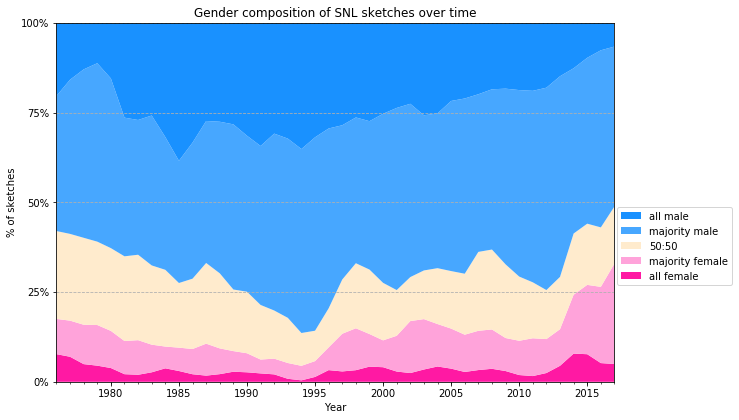

In [38]:
# (3, triang), (5, parzen)
ax = plot_gender_ratio(window=5, rolling_kwargs=dict(win_type='parzen'))
#ax.grid(True, axis='x', which='minor')
ax.set_title('Gender composition of SNL sketches over time');

<small>Some notes on how this was calculated:
- Only cast members are counted - not hosts or cameo appearances. If a sketch has 2 female cast members, 2 male cast members, and the (male) host, it will be counted as 50:50, rather than majority male.
- I counted sketches, live or filmed. I did not include the host's monologue or Weekend Update. 
- A sketch had to have at least 2 cast members to be counted.

But the overall trend is pretty robust in the face of changes to the above parameters.</small>

The last few seasons do stand out pretty remarkably in terms of female-dominated sketches. Starting in season 40, for the first time, more than 1 out of 4 sketches had more women than men. The last season also represents an all-time low for all-male sketches, a continuation of a pretty steady decades-long trend.

# Chick Sketches and Guy Sketches

It's interesting to peek at a few examples of all-female and all-male sketches through the ages.

Below I randomly sampled from each season one sketch meeting the following criteria:
- At least 3 performers
- All of them women (including the host, if present)

These are slightly more stringent than the criteria I used for measuring 'all-female' sketches in the chart above, but it still doesn't seem like a very high bar to clear. But remarkably, there are 8 seasons with not a single such sketch.

In [27]:
import itertools
import requests
import cv2
import math
import logging
import textwrap
from bs4 import BeautifulSoup as Soup

# XXX
placeholder_tid = 198904157

def sample_monogender_sketches(gender, n=10, sid_range=None, min_performers=2, soft=False, epsilon=.2, per_season=False):
    assert gender in ('male', 'female')
    cats = gender_ratio_categories
    cols = ['tid', 'category', 'name', 'epid', 'n_performers', 'n_female_plus', 'n_male_plus', 'sid']
    if soft:
        ratio_ix = (titles['female_ratio_plus'] >= 1-epsilon) if gender == 'female' else (titles['female_ratio_plus'] <= epsilon)
    else:
        target_ratio = 0 if gender == 'male' else 1
        ratio_ix = titles['female_ratio_plus'] == target_ratio
    title_idx = (
        titles['category'].isin(cats)
        & (titles['n_performers'] >= min_performers)
        & ratio_ix
    )
    if per_season:
        tids = []
        sids = range(sid_range[0], sid_range[1]+1) if sid_range else seasons.index
        for sid in sids:
            sidx = titles['sid'] == sid
            idx = title_idx & sidx
            if idx.sum() == 0:
                #logging.warn('No eligible sketches for season {}'.format(sid))
                tid = placeholder_tid
            else:
                tid = titles.loc[idx, 'tid'].sample(1, random_state=1337).iloc[0]
            tids.append(tid)
        return titles.loc[tids, cols]
        #return pd.concat(rows)
        #return rows
    if sid_range:
        title_idx &= (titles['sid'] >= sid_range[0]) & (titles['sid'] <= sid_range[1])
    return titles.loc[title_idx, cols].sample(n, random_state=1337)

def thumbnail_fname(tid):
    tid = str(tid)
    parts = tid[:4], tid[4:6], tid[6:8], tid[8:]
    return '-'.join(parts) + '.jpg'

def thumbnail_url(skit):
    if skit.category == 'Commercial':
        # NB: ugh, I guess .name refers to some pandas builtin property...
        try:
            name = skit.loc['name']
        except AttributeError:
            name = skit.name
        return 'http://www.snlarchives.net/images/Commercial/{}.jpg'.format(name)
    else:
        tid = skit.tid
        fname = thumbnail_fname(tid)
        # example url: /images/EpisodeSketch/1975-10-11-3.jpg
        return 'http://www.snlarchives.net/images/EpisodeSketch/{}'.format(fname)

def scrape_thumbnail_url(skit):
    url = 'http://www.snlarchives.net/Episodes/?{}'.format(skit.tid)
    title_pg = requests.get(url, timeout=2)
    soup = Soup(title_pg.content, 'lxml')
    url = None
    for class_ in ['imageSD', 'imageHD']:
        matches = soup.find_all(class_=class_)
        assert len(matches) <= 1
        if len(matches) == 0:
            continue
        div = matches[0]
        style = div.attrs['style']
        assert style.startswith('background-image')
        # bleh
        url = style.split("'")[1]
        break
    assert url
    return 'http://www.snlarchives.net' + url

def get_thumbnail(skit):
    tid = skit.tid
    path = os.path.join(thumbnail_dir, thumbnail_fname(tid))
    if not os.path.exists(path):
        #print "cache miss"
        dl_thumbnail(skit)
    img = cv2.imread(path)
    assert img is not None, 'Bad img data at {}'.format(path)
    return img
    
def dl_thumbnail(skit):
    tid = skit.tid
    fname = thumbnail_fname(tid)
    try:
        url = thumbnail_url(skit)
        resp = requests.get(url, timeout=2)
        assert resp.ok, 'Error {} - {} ({})'.format(resp.status_code, resp.reason, url)
    except:
        logging.warn('Thumbnail url for skit {} ({}) failed. Falling back to scraping html'.format(
            skit.name, tid
        ))
        url = scrape_thumbnail_url(skit)
        resp = requests.get(url, timeout=2)
        assert resp.ok, 'Error {} - {} ({})'.format(resp.status_code, resp.reason, url)
    path = os.path.join(thumbnail_dir, fname)
    dat = resp.content
    with open(path, 'w') as f:
        f.write(dat)
        
def _show(ax, img):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.tick_params(which='both', 
                   bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labeltop=False, labelleft=False, labelright=False,
                  )
    ax.grid(False, which='both')

thumbnail_dir = 'thumbs'
def plot_collage(skits, sort=False):
    n = len(skits)
    cols = 5
    rows = int(math.ceil(n / cols))
    row_height = 2.5
    fs = (DEFAULT_W*1.5, row_height*rows)
    fig, axes = plt.subplots(rows, cols, figsize=fs)
    if sort:
        skits = skits.sort_values(by='epid', ascending=True)
    yr1 = seasons.loc[skits.iloc[0]['sid'], 'year']
    for i, (skit, ax) in enumerate(
        itertools.izip_longest(skits.itertuples(index=True), axes.flatten())
    ):
        if skit is None:
            ax.axis('off')
            continue
        if skit.tid == placeholder_tid:
            ax.axis('off')
            year = yr1+i
            ax.set_title('N/A - {}'.format(year))
            continue
        tid = str(skit.tid)
        img = get_thumbnail(skit)
        _show(ax, img)
        yr = seasons.loc[skit.sid, 'year']
        skitname = skit.name
        if len(skitname) > 50:
            skitname = skitname[:50] + '...'
        # Escape $ so matplotlib doesn't get confused and think this is tex
        skitname = skitname.replace('$', r'\$')
        title = '{} - {}'.format(skitname, yr)
        max_w = 27
        title_str = '\n'.join(textwrap.wrap(title, max_w))
        ax.set_title(title_str)
        #ax.set_xlabel(yr)
    plt.subplots_adjust(hspace=.4)

In [13]:
#skits = sample_monogender_sketches('female', n=12, min_performers=3, soft=0)
#plot_collage(skits, sort=True)

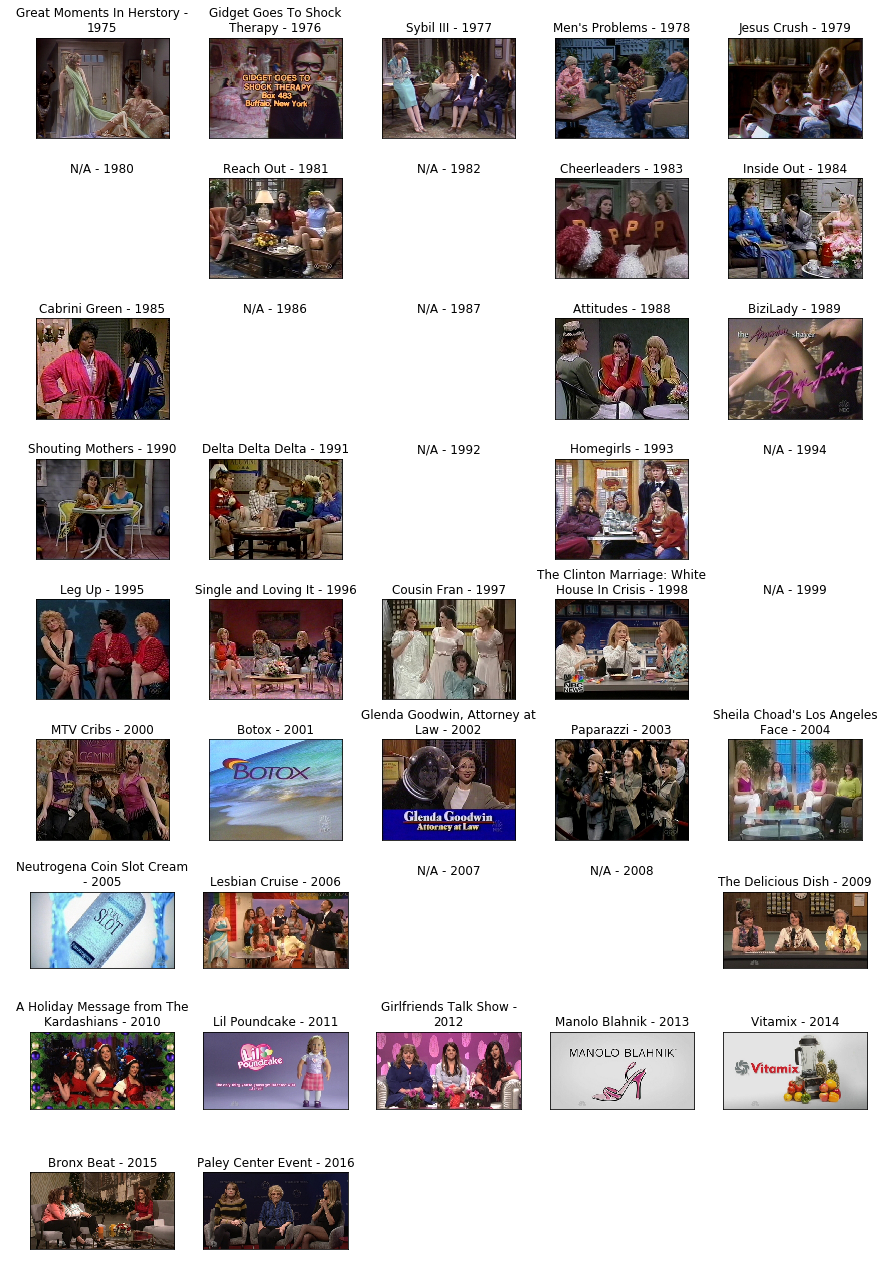

In [28]:
skits = sample_monogender_sketches('female', n=2, min_performers=3, soft=0, sid_range=(1,42), per_season=1, epsilon=.19)
#skits = sample_monogender_sketches('female', n=2, min_performers=3, soft=0, sid_range=(1,42), per_season=1)
plot_collage(skits)

Here's the same thing for all-male sketches through the ages.

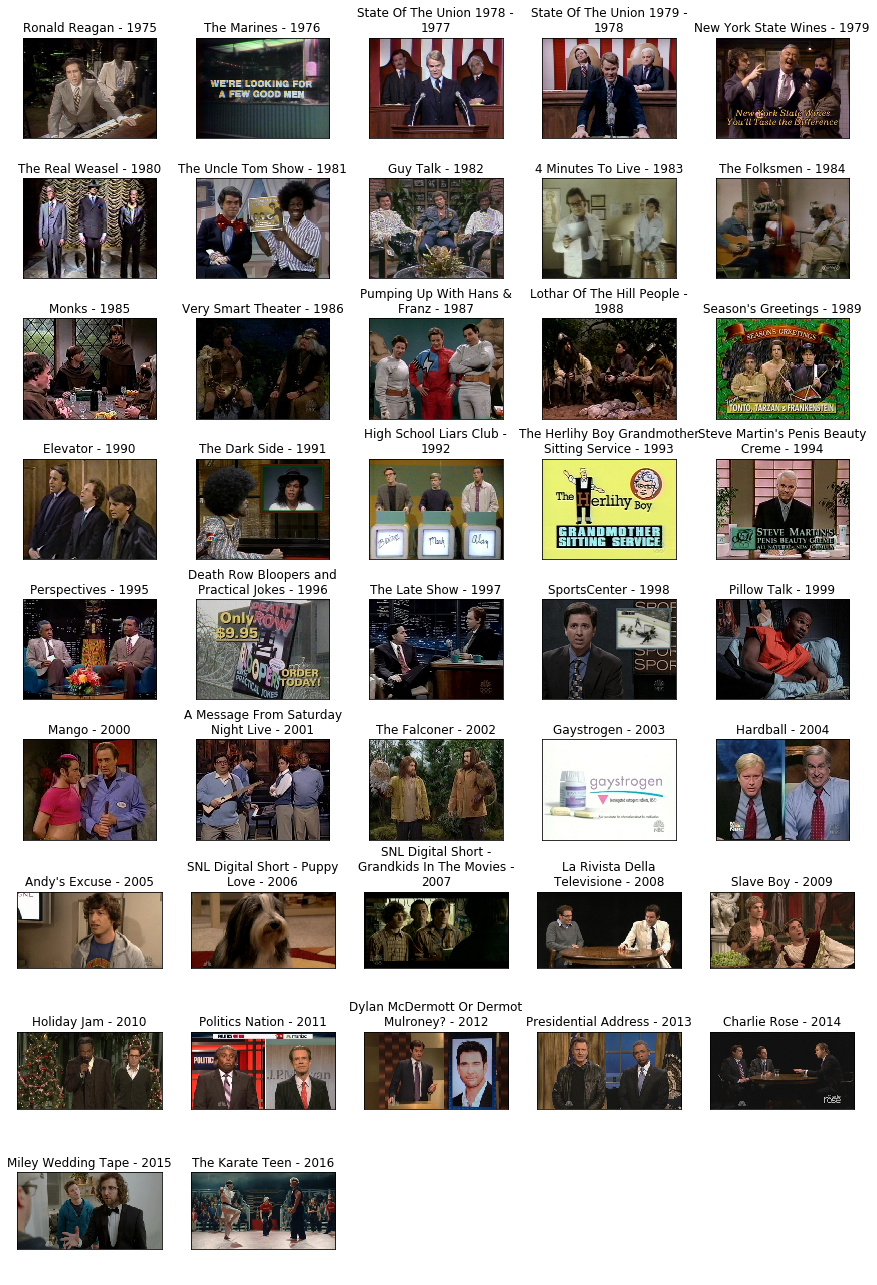

In [29]:
skits = sample_monogender_sketches('male', n=2, min_performers=3, soft=0, sid_range=(1,42), per_season=1, epsilon=.19)
plot_collage(skits)

It's interesting to note that the majority of the all-female sketches are about explicitly 'girly' topics (e.g. 'Neutrogena Coin Slot Cream', 'Cheerleaders', 'Lesbian Cruise'). On the other hand, a handful of the all-male sketches are gender-specific ("Steve Martin's Penis Beauty Creme", "Guy Talk"), but the majority aren't "guy sketches" - they're just sketches.

# Effect of cast demographics

The gender makeup of SNL sketches has changed considerably over time. But so has the gender makeup of the show's cast.

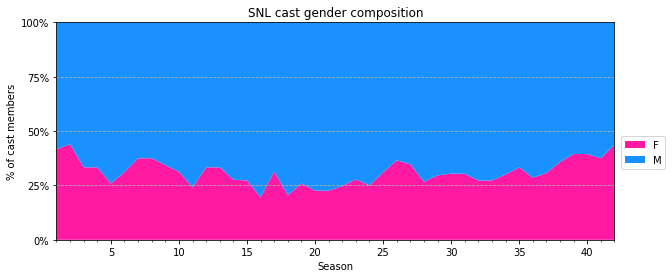

In [30]:
ax = stackplot_cast_gender(collapse=1, norm=1, stack=1)
ax.set_ylabel('% of cast members');

Maybe the changes in sketch demographics are just a straightforward consequence of changes to the cast.

We can compute the predicted distribution of male/female-dominated sketches under a null hypothesis where we imagine that the number of roles in each sketch is fixed, and we cast those roles by selecting performers from the cast uniformly at random, without replacement. The result looks like this:

In [17]:
#ax = stackplot_cast_gender(collapse=0, norm=0, stack=1);
#ax.grid(True, axis='x', which='minor')

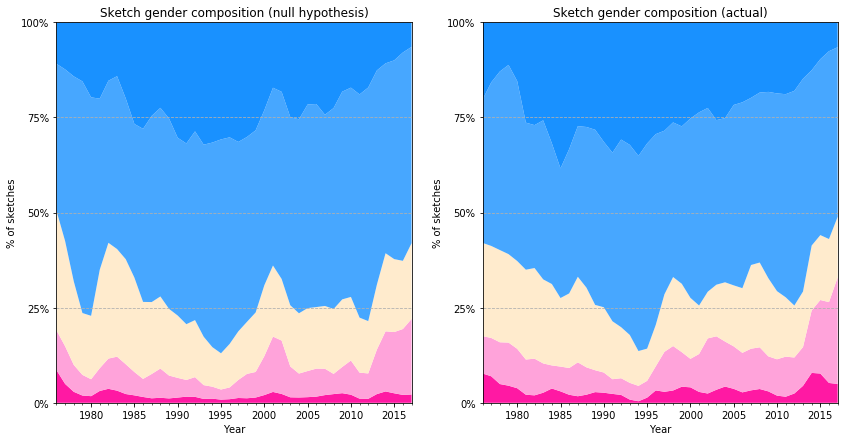

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
plot_baselines(nrounds=100, ax=ax1, window=5, rolling_kwargs=dict(win_type='parzen'));
ax1.set_title('Sketch gender composition (null hypothesis)')
plot_gender_ratio(ax=ax2, window=5, rolling_kwargs=dict(win_type='parzen'))
ax2.set_title('Sketch gender composition (actual)')
ax1.legend_.remove()
ax2.legend_.remove()

Our null hypothesis actually predicts reality pretty well. The main difference is that the number of all-female and majority-female sketches are pretty consistently underestimated. (In our simulation, we still haven't crossed the 25% threshold, which was in reality crossed in season 40)

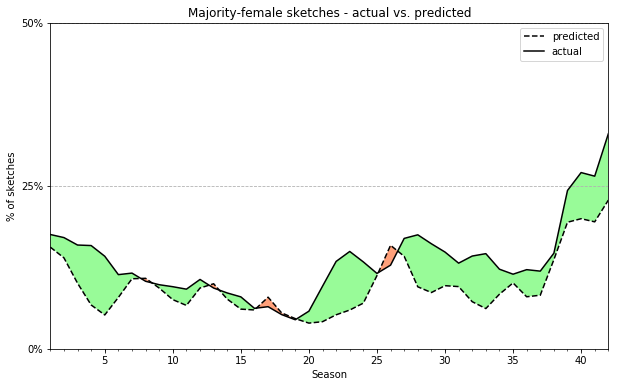

In [19]:
ax, _ = plot_delta(0, 1)
ax.set_title('Majority-female sketches - actual vs. predicted')
ax.set_ylim(top=.5);

The green/orange regions represent how much majority female sketches are overrepresented/underrepresented compared to what would be expected by chance.

The data points to around 4 distinct eras of female excellence on SNL, where majority-female sketches are overrepresented. Each lines up with a cohort of MVP female cast members who joined and left around the same time:
1. The early years (Gilda Radner, Jane Curtin, Laraine Newman)
2. The mid-to-late-90's (Molly Shannon, Cheri Oteri, Ana Gasteyer)
3. The era of funny women from Chicago (Tina Fey, Amy Poehler, Rachel Dratch), plus Maya Rudolph, and later Kristen Wiig (whose tenure on the show almost comprises an era of its own).
4. The modern era (Kate McKinnon, Cecily Strong, Vanessa Bayer, Aidy Bryant)

It's interesting to note the contractions between each of the last 3, marking 'rebuilding years'.

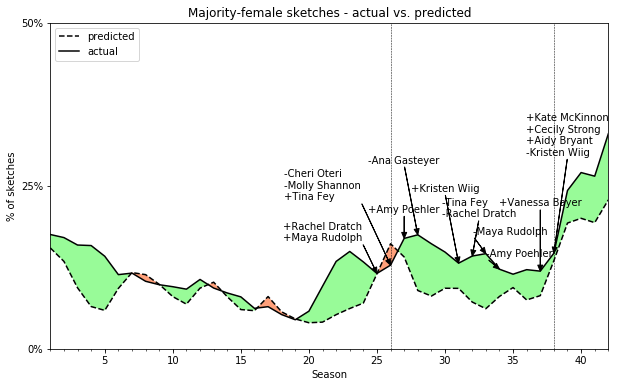

In [20]:
import random
ax, yy = plot_delta(0, 1)
ax.set_title('Majority-female sketches - actual vs. predicted')
ax.set_ylim(top=.5);
events = [
    (25, '+Rachel Dratch\n+Maya Rudolph', -4, .05),
    (26, '-Cheri Oteri\n-Molly Shannon\n+Tina Fey', -5, .1),
    (27, '+Amy Poehler', 0, .04),
    (28, '-Ana Gasteyer', -1, .11),
    (31, '+Kristen Wiig', -1, .11),
    (32, '-Tina Fey\n-Rachel Dratch', 0.5, .06),
    (33, '-Maya Rudolph', 1.8, .03),
    (34, '-Amy Poehler', 1.5, .02),
    (37, '+Vanessa Bayer', 0, .1),
    (38, '+Kate McKinnon\n+Cecily Strong\n+Aidy Bryant\n-Kristen Wiig', 1, .15)
]
random.seed(133)
ax.grid(False, axis='y')
for x, text, dx, dy in events:
    #ax.axvline(x=x, color='black', lw=.5, ls='--')
    #yjitter = random.gauss(0, .05)
    y = yy[x-1]
    ax.annotate(text, xy=(x, y), xytext=(x+dx, y+dy),
            arrowprops=dict(facecolor='black', width=.1, headwidth=5, headlength=6),
                horizontalalignment='center', multialignment='left',
           )

vlines = [26, 38]
for x in vlines:
    ax.axvline(x=x, color='black', lw=.5, ls='--')

There's a pretty clear 'pinch' from seasons 25-27, between the exit of key players from the previous generation (Oteri, Shannon), and the new guard finding their feet.

Season 38 represents another major rebuilding year. This is the first season without Kristen Wiig (Fey, Poehler, et. al having left long ago). Future MVPs Kate McKinnon, Cecily Strong, and Aidy Bryant all joined as featured players in this season, with Vanessa Bayer having joined the year earlier.

Outside of these golden ages, there also seems to exist a notable 'dark age' for women on SNL which stretches through all of the 80's into the early 90's, up to about season 20. During this time, a lot of very funny women joined the show, failed to thrive there, and left after one or two seasons: e.g. Janeane Garofalo, Sarah Silverman, Julia-Louis Dreyfus. A lot of undeniable stars emerged during this time - Eddie Murphy, Phil Hartman, Adam Sandler, Chris Farley, Dana Carvey, Mike Meyers... - but it's essentially a list of men.

If you're interested in analyzing this kind of SNL data, check out snldb on [GitHub](https://github.com/hhllcks/snldb) or [Kaggle](https://www.kaggle.com/hhllcks/snldb).

<!-- Our model also typically under-estimates the number of entirely-male sketches on the show. -->

In [21]:
#ax, _ = plot_delta(4)
#ax.set_title('All-male sketches - actual vs. predicted');

<!-- In effect, the sketches are slightly more gender-segregated than would be expected by chance. To some degree, the men and women of SNL stick together. -->


<!-- One effect our null hypothesis model fails to account for is that the cast is divided into 'featured' and 'repertory' players. Featured players are typically in their first year or two on the show, and they tend to appear in far fewer sketches. If women are consistently underrepresented among featured players, that could explain some of our model's bias. -->

In [22]:
if 0:
    ax = stackplot_cast_gender(collapse=0, norm=0, stack=1)

<!-- But even in season 35, where 3 of the show's 4 female cast members were featured players, majority-female sketches are underestimated. -->